# Day 7: Handy Haversacks

You land at the regional airport in time for your next flight. In fact, it looks like you'll even have time to grab some food: all flights are currently delayed due to issues in luggage processing.

Due to recent aviation regulations, many rules (your puzzle input) are being enforced about bags and their contents; bags must be color-coded and must contain specific quantities of other color-coded bags. Apparently, nobody responsible for these regulations considered how long they would take to enforce!

For example, consider the following rules:

    light red bags contain 1 bright white bag, 2 muted yellow bags.
    dark orange bags contain 3 bright white bags, 4 muted yellow bags.
    bright white bags contain 1 shiny gold bag.
    muted yellow bags contain 2 shiny gold bags, 9 faded blue bags.
    shiny gold bags contain 1 dark olive bag, 2 vibrant plum bags.
    dark olive bags contain 3 faded blue bags, 4 dotted black bags.
    vibrant plum bags contain 5 faded blue bags, 6 dotted black bags.
    faded blue bags contain no other bags.
    dotted black bags contain no other bags.

These rules specify the required contents for 9 bag types. In this example, every faded blue bag is empty, every vibrant plum bag contains 11 bags (5 faded blue and 6 dotted black), and so on.

You have a shiny gold bag. If you wanted to carry it in at least one other bag, how many different bag colors would be valid for the outermost bag? (In other words: how many colors can, eventually, contain at least one shiny gold bag?)

In the above rules, the following options would be available to you:

    A bright white bag, which can hold your shiny gold bag directly.
    A muted yellow bag, which can hold your shiny gold bag directly, plus some other bags.
    A dark orange bag, which can hold bright white and muted yellow bags, either of which could then hold your shiny gold bag.
    A light red bag, which can hold bright white and muted yellow bags, either of which could then hold your shiny gold bag.

So, in this example, the number of bag colors that can eventually contain at least one shiny gold bag is 4.

How many bag colors can eventually contain at least one shiny gold bag? (The list of rules is quite long; make sure you get all of it.)

In [1]:
# Python imports
from math import prod
from pathlib import Path
from typing import List, Tuple

import networkx as nx

This can be represented as a graph problem.

Consider that each bag is a node in a graph, then each edge from bag `A` to bag `B` represents the relationship `A contains B`; this is a directed graph. The edges are also weighted because `A` may contain a variable number of bags `B`.

We write two functions: one to parse a single line of a rule from the input file; the other to load the rule file and return a `networkx` directed graph representing the rules.

In [2]:
def parse_rule(line: str) -> Tuple[str, List[Tuple[str, int]]]:
    """Parse a single line from a rule file into a tuple of (outer, inner) bag data
    
    :param line:  Rule formatted as 
                  "<colour> bags contain [<count> <colour>|, ...] bags."
                  
    Returns a tuple of (<outer bag colour>, <list of inner bag colours and counts>)
    """
    outer, inner = line.split(" bags contain ")

    # Identify colours and counts of contained bags
    contents = []
    for inbag in inner.split(", "):
        elems = inbag.split()
        try:
            num = int(elems[0])
            colour = f"{elems[1]} {elems[2]}"
            contents.append((colour, num))
        except ValueError:  # no contents
            pass
    
    return (outer, contents)

In [3]:
def load_rules(fpath: str) -> nx.DiGraph:
    """Return nx.Digraph defined by rules in passed file
    
    :param fpath:  path to file containing rules for bag containment
    """
    bags = nx.DiGraph()
    with Path(fpath).open("r") as ifh:
        for line in ifh.readlines():
            outer, contents = parse_rule(line.strip()[:-1])
            bags.add_node(outer, bag_count=1)
            for colour, num in contents:
                bags.add_node(colour, bag_count=1)
                bags.add_edge(outer, colour, weight=num)
    return bags

We can use `networkx`'s `nx.has_path()` function to identify whether a path exists *from* each node to the query node (here, "shiny gold"). A straightforward approach is to count all nodes in the graph that possess such a path.

Solving the test puzzle.

In [4]:
rules = load_rules("day07_test.txt")
sum([nx.has_path(rules, node, "shiny gold") for node in rules]) - 1 # no self-loops allowed

4

Solving the real puzzle.

In [5]:
rules = load_rules("day07_data.txt")
sum([nx.has_path(rules, node, "shiny gold") for node in rules]) - 1 # no self-loops allowed

213

# Puzzle 2

It's getting pretty expensive to fly these days - not because of ticket prices, but because of the ridiculous number of bags you need to buy!

Consider again your shiny gold bag and the rules from the above example:

    faded blue bags contain 0 other bags.
    dotted black bags contain 0 other bags.
    vibrant plum bags contain 11 other bags: 5 faded blue bags and 6 dotted black bags.
    dark olive bags contain 7 other bags: 3 faded blue bags and 4 dotted black bags.

So, a single shiny gold bag must contain 1 dark olive bag (and the 7 bags within it) plus 2 vibrant plum bags (and the 11 bags within each of those): 1 + 1 * 7 + 2 + 2 * 11 = 32 bags!

Of course, the actual rules have a small chance of going several levels deeper than this example; be sure to count all of the bags, even if the nesting becomes topologically impractical!

Here's another example:

    shiny gold bags contain 2 dark red bags.
    dark red bags contain 2 dark orange bags.
    dark orange bags contain 2 dark yellow bags.
    dark yellow bags contain 2 dark green bags.
    dark green bags contain 2 dark blue bags.
    dark blue bags contain 2 dark violet bags.
    dark violet bags contain no other bags.

In this example, a single shiny gold bag must contain 126 other bags.

How many individual bags are required inside your single shiny gold bag?

To solve this, we develop an algorithm that starts at *termini* of the graph (nodes with zero outdegree, that is: bags that contain no other bags).

We take each such *terminus* in turn, and look at the edges leading in to the terminus, to see which nodes it is connected to (i.e. we look at each of the bags that contain the bag we're currently considering). The edge weight represents the bag containment rule, so if the edge weight is 3, say, the *containing* bag contains 3 terminus bags.

All the nodes/bags in the graph have a count (`bag_count`) stating how many bags they contain (plus one to represent the bag itself). So we update the number of bags in the upstream *containing* bag to be the *weight* of the edge multiplied by the number of bags in the terminal bag (including itself).

Once we have done this for a single terminal node, we remove that node from the graph, and move to the next terminus. When we run out of termini, we check to see if we've created new terminal nodes, and repeat the process.

If we hit our query node as a "terminal" then its number will no longer be updated by downstream nodes, so we can stop and report the number of bags it contains (its `bag_count` - 1).

This algorithm is encoded in the `bagception_number()` function below.

In [6]:
def bagception_number(graph: nx.DiGraph, node: str) -> int:
    """Returns the number of other bags contained by a specified bag.
    
    :param node:  the name of the query node
    """
    # initial set of terminal nodes
    termini = [node for node, deg in graph.out_degree if deg == 0]

    while len(termini):  # loop while there are still termini
        curnode = termini.pop(0)  # pop a terminus off the left end of the list
        curbags = nx.get_node_attributes(graph, "bag_count")[curnode] # number of bags at current node 

        if curnode == node:  # have we hit our node? If so, report contained bags
            return nx.get_node_attributes(graph, "bag_count")[node] - 1

        for pred in rules.predecessors(curnode):  # loop over predecessor nodes
            weight = graph[pred][curnode]["weight"]  # get edge weight
            predbags = nx.get_node_attributes(graph, "bag_count")[pred] # how many bags at predecessor
            newbags = predbags + curbags * weight  # new number of bags at predecessory
            rules.add_node(pred, bag_count=newbags)  # update graph

        graph.remove_node(curnode)  # remove the terminus we were working with
        
        # Update the list with any new termini
        termini.extend([node for node, deg in graph.out_degree if deg == 0 and node not in termini])
        
    return 0  # Only happens if we don't find our query node

Solving the example problems

In [7]:
rules = load_rules("day07_test.txt")
bagception_number(rules, "shiny gold")

32

In [8]:
rules = load_rules("day07_test2.txt")
bagception_number(rules, "shiny gold")

126

Solving the real puzzle.

In [9]:
rules = load_rules("day07_data.txt")
bagception_number(rules, "shiny gold")

38426

## Rendering graphs with `networkx`

To get inspiration/understand your algorithm development process it can be useful to visualise the graph representation of your data. `networkx` has functions to help with that.

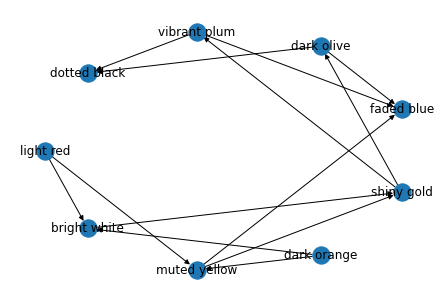

In [10]:
rules = load_rules("day07_test.txt")
nx.draw_shell(rules, with_labels=True)

In [ ]:
rules = load_rules("day07_test2.txt")
nx.draw_shell(rules, with_labels=True)